# Introduction to Quantum Computing Project - Binary Classification on the Parity problem

This focuses on identifying the "best" model from experiments by running multiple optimizers/learning rates and selecting top performers.

Install pennylane

In [1]:
%pip install pennylane
%pip install pandas
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.4 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer, GradientDescentOptimizer, RMSPropOptimizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


# Data
Data is generated using the parity function. The parity function is a function that returns 1 if the number of 1s in the input is odd, and 0 otherwise. The input is a binary string of length n. The parity function is a well-known example of a function that is not efficiently learnable by a classical neural network. However, it can be learned efficiently by a quantum neural network.

## Read

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

base_path = "/content/drive/MyDrive/Colab Notebooks/data"

train_classA = np.loadtxt(f"{base_path}/classA_train.dat")
train_classB = np.loadtxt(f"{base_path}/classB_train.dat")
test_classA = np.loadtxt(f"{base_path}/classA_test.dat")
test_classB = np.loadtxt(f"{base_path}/classB_test.dat")
train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

## Preprocess

In [5]:
train_classA -= 0.5
train_classB -= 0.5
test_classA -= 0.5
test_classB -= 0.5

Creating train and test datasets

In [6]:
train_data = np.vstack((train_classA, train_classB))
train_labels = np.hstack((np.zeros(len(train_classA)), np.ones(len(train_classB))))

test_data = np.vstack((test_classA, test_classB))
test_labels = np.hstack((np.zeros(len(test_classA)), np.ones(len(test_classB))))

#Preview

In [7]:
train_data

tensor([[-0.52136932,  0.51634261,  0.57685187],
        [ 0.47967195,  0.47521001, -0.48276349],
        [ 0.45851495,  0.48880249, -0.47751312],
        [ 0.47287287,  0.50130472, -0.48129676],
        [ 0.4490846 ,  0.49955922, -0.53082429],
        [-0.46906929, -0.51708618, -0.51294948],
        [ 0.40494731,  0.57586463, -0.5228194 ],
        [-0.46868174, -0.51639052, -0.50394778],
        [ 0.45230147,  0.53798005, -0.47490086],
        [ 0.44109225, -0.48876122,  0.49780467],
        [ 0.55928369,  0.53811759, -0.49537057],
        [-0.48554956,  0.5311928 ,  0.53043502],
        [-0.49101668, -0.52985789, -0.49328596],
        [ 0.56489058,  0.52622874, -0.47390937],
        [ 0.50082764, -0.5481794 ,  0.49814355],
        [-0.49541045, -0.46895463, -0.44893712],
        [-0.45864197, -0.47720196, -0.53279515],
        [ 0.56208121, -0.49005089,  0.50610096],
        [-0.57611053,  0.46526223,  0.47765986],
        [ 0.4342591 , -0.49482992,  0.52829108],
        [-0.4194763 

In [8]:
test_data

tensor([[ 0.4879638 ,  0.54024352, -0.46494221],
        [-0.49177858, -0.51371639, -0.47245236],
        [ 0.49295538, -0.4814586 ,  0.48787918],
        [ 0.55597339,  0.5324364 , -0.49658654],
        [-0.52495464, -0.48868671, -0.51545709],
        [-0.45134428, -0.52187662, -0.53744429],
        [-0.51112591,  0.53013485,  0.51654904],
        [ 0.52916993, -0.49962332,  0.51428079],
        [-0.4897708 ,  0.4922424 ,  0.5334223 ],
        [-0.46431262, -0.45484039, -0.50036212],
        [ 0.51488301, -0.53164158, -0.52451988],
        [-0.49771912,  0.52398959, -0.49891081],
        [-0.50994703,  0.45064989, -0.48652751],
        [ 0.41944514, -0.54143044, -0.54457641],
        [ 0.52296955, -0.50002518, -0.52334696],
        [-0.45378063,  0.47989627, -0.47546236],
        [-0.47659954,  0.4897321 , -0.51949139],
        [-0.4566875 ,  0.51162301, -0.47473584],
        [ 0.45832342,  0.51347606,  0.48019078],
        [ 0.46999107, -0.51461362, -0.50094802]], requires_grad=True)

## Visualizing input data

2-dimensional. showing the difficulty of the problem in a 2-dimensional space.

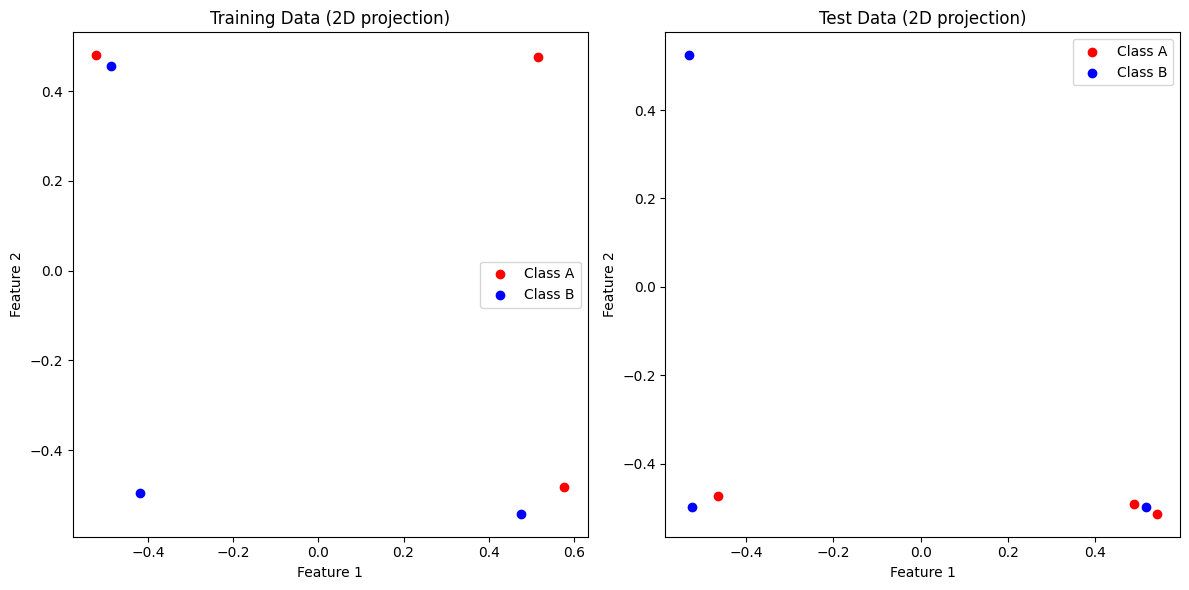

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(train_classA[0], train_classA[1], color='red', label='Class A')
ax1.scatter(train_classB[0], train_classB[1], color='blue', label='Class B')
ax1.set_title('Training Data (2D projection)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend()

ax2.scatter(test_classA[0], test_classA[1], color='red', label='Class A')
ax2.scatter(test_classB[0], test_classB[1], color='blue', label='Class B')
ax2.set_title('Test Data (2D projection)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()

plt.tight_layout()
plt.show()

3-dimensional. Cubes are now well separated.

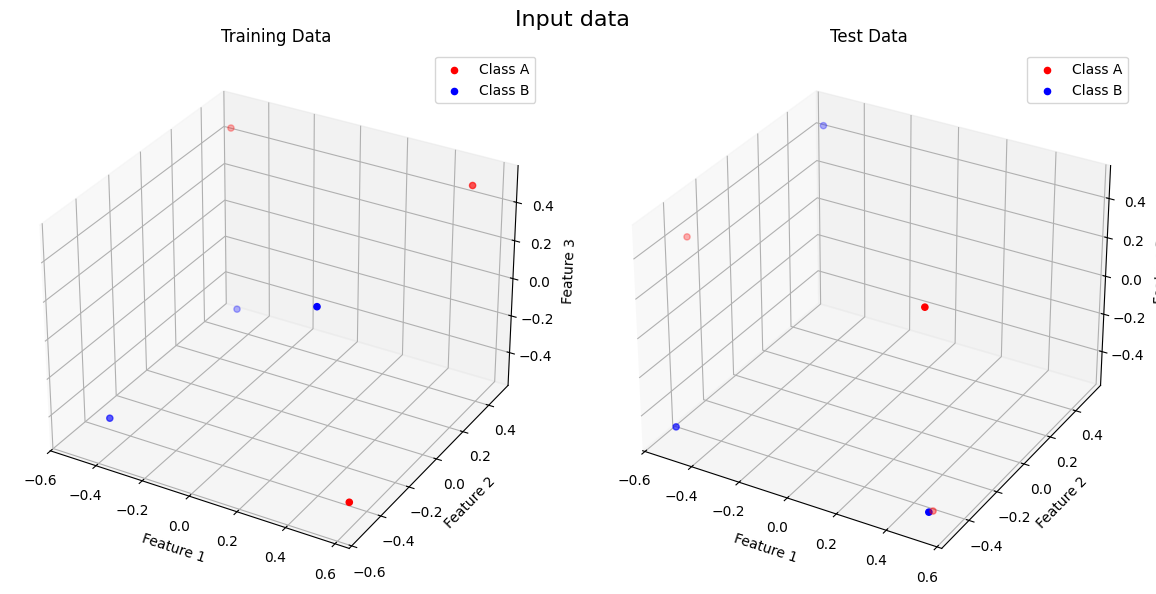

In [10]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_classA[0], train_classA[1], train_classA[2], color='red', label='Class A')
ax1.scatter(train_classB[0], train_classB[1], train_classB[2], color='blue', label='Class B')
ax1.set_title('Training Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_classA[0], test_classA[1], test_classA[2], color='red', label='Class A')
ax2.scatter(test_classB[0], test_classB[1], test_classB[2], color='blue', label='Class B')
ax2.set_title('Test Data')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')
ax2.legend()

fig.suptitle('Input data', fontsize=16)
plt.tight_layout()
plt.show()

# Quantum Binary Classifiers - Best Data reUploading Circuit

For building the classifier I will use the pennylane python toolkit.

In [11]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss /= len(labels)
    return loss

In [12]:
def plot_metrics(iterations, train_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].plot(iterations, train_losses, label='Training Loss')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Iterations vs Training Loss')
    axs[0].legend()

    axs[1].plot(iterations, train_accuracies, label='Training Accuracy', color='orange')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Iterations vs Training Accuracy')
    axs[1].legend()

    axs[2].plot(iterations, test_accuracies, label='Test Accuracy', color='green')
    axs[2].set_xlabel('Iterations')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Iterations vs Test Accuracy')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

## Data reUploading Circuit

### Initialize the circuit Params

In [13]:
n_qubits = train_data.shape[1]
num_reuploads = 5
dev = qml.device("default.qubit", wires=n_qubits)

### Circuit

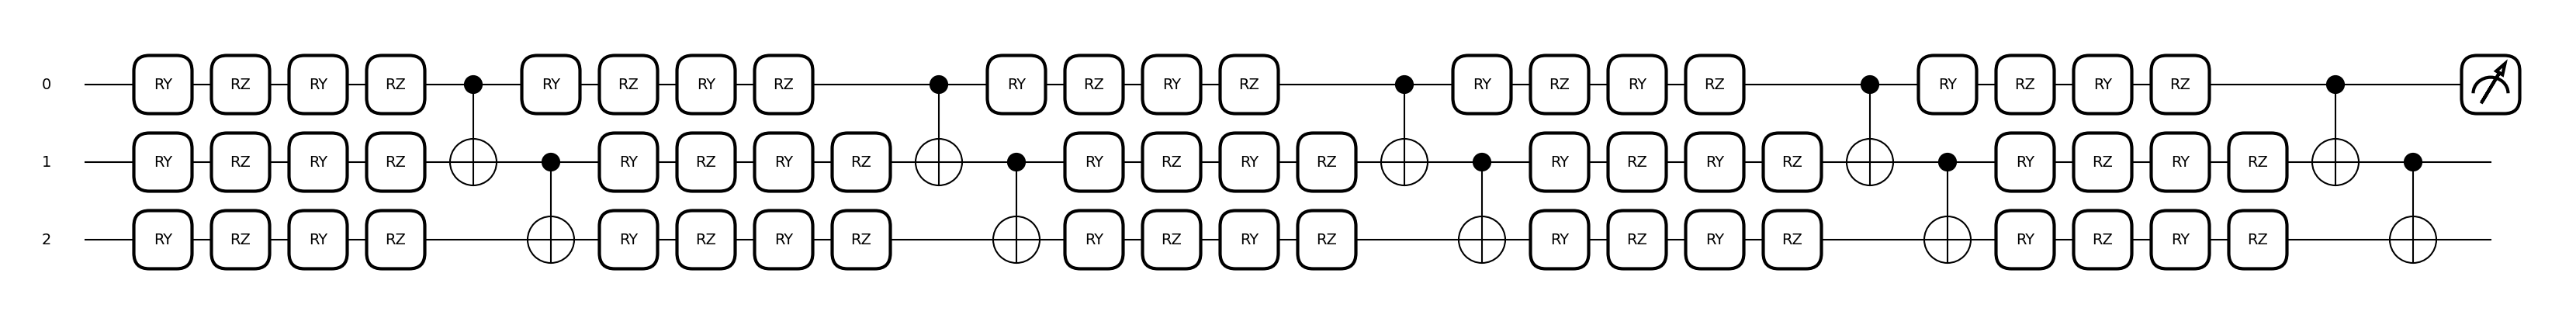

In [14]:
def circuit(weights, x):
    for layer in range(num_reuploads):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RY(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

qnode = qml.QNode(circuit, dev)

weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
fig, ax = qml.draw_mpl(circuit)(weights_init, np.zeros(n_qubits))
plt.show()

### Training

In [15]:
def variational_classifier(weights, bias, x):
    return qnode(weights, x) + bias

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

def train(X, Y, num_reuploads, optimizer, learning_rate=0.1, epochs=50, batch_size=5):
    np.random.seed(0)
    weights_init = 0.01 * np.random.randn(num_reuploads, n_qubits, 3)
    bias_init = np.array(0.0, requires_grad=True)

    opt = optimizer(learning_rate)
    weights = weights_init
    bias = bias_init

    train_costs = []
    test_accuracies = []
    train_accuracies = []

    for it in range(epochs):
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

        train_predictions = [variational_classifier(weights, bias, x) for x in X]
        train_acc = np.mean((np.array(train_predictions) > 0.5) == Y)

        test_predictions = [variational_classifier(weights, bias, x) for x in test_data]
        test_acc = np.mean((np.array(test_predictions) > 0.5) == test_labels)

        train_costs.append(cost(weights, bias, X, Y))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(f"Iter: {it+1} | Train Cost: {cost(weights, bias, X, Y):.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

    return weights, bias, train_costs, train_accuracies, test_accuracies


### Evaluate

In [16]:
def evaluate(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    accuracy = np.mean((predictions > 0.5) == Y)
    print(f"Accuracy: {accuracy:.4f}")
    return predictions, accuracy

def visualize_performance(X, Y, predictions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    correctly_classified = (predictions > 0.5) == Y
    incorrectly_classified = ~correctly_classified

    ax.scatter(X[correctly_classified, 0], X[correctly_classified, 1], X[correctly_classified, 2], c='green', marker='o', label='Correctly Classified')
    ax.scatter(X[incorrectly_classified, 0], X[incorrectly_classified, 1], X[incorrectly_classified, 2], c='red', marker='x', label='Incorrectly Classified')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title("Data Classification Performance")
    ax.legend()
    plt.show()

Iter: 1 | Train Cost: 0.4194 | Train Accuracy: 0.4500 | Test Accuracy: 0.5500
Iter: 2 | Train Cost: 0.3766 | Train Accuracy: 0.4500 | Test Accuracy: 0.5000
Iter: 3 | Train Cost: 0.3351 | Train Accuracy: 0.4750 | Test Accuracy: 0.5500
Iter: 4 | Train Cost: 0.3307 | Train Accuracy: 0.5500 | Test Accuracy: 0.5500
Iter: 5 | Train Cost: 0.3612 | Train Accuracy: 0.5750 | Test Accuracy: 0.5500
Iter: 6 | Train Cost: 0.2992 | Train Accuracy: 0.5750 | Test Accuracy: 0.5500
Iter: 7 | Train Cost: 0.2492 | Train Accuracy: 0.5750 | Test Accuracy: 0.5500
Iter: 8 | Train Cost: 0.2171 | Train Accuracy: 0.6500 | Test Accuracy: 0.6500
Iter: 9 | Train Cost: 0.1923 | Train Accuracy: 0.8000 | Test Accuracy: 0.9000
Iter: 10 | Train Cost: 0.1779 | Train Accuracy: 0.8000 | Test Accuracy: 0.9000
Iter: 11 | Train Cost: 0.1672 | Train Accuracy: 0.7750 | Test Accuracy: 0.9000
Iter: 12 | Train Cost: 0.1661 | Train Accuracy: 0.7250 | Test Accuracy: 1.0000
Iter: 13 | Train Cost: 0.1780 | Train Accuracy: 0.6250 | Test

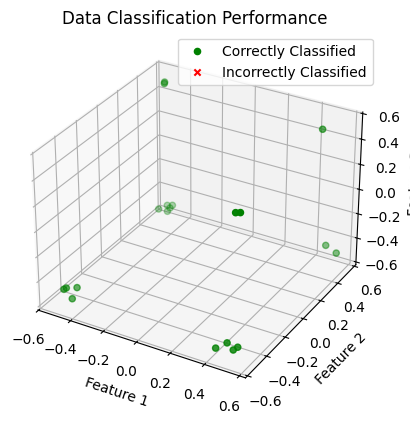

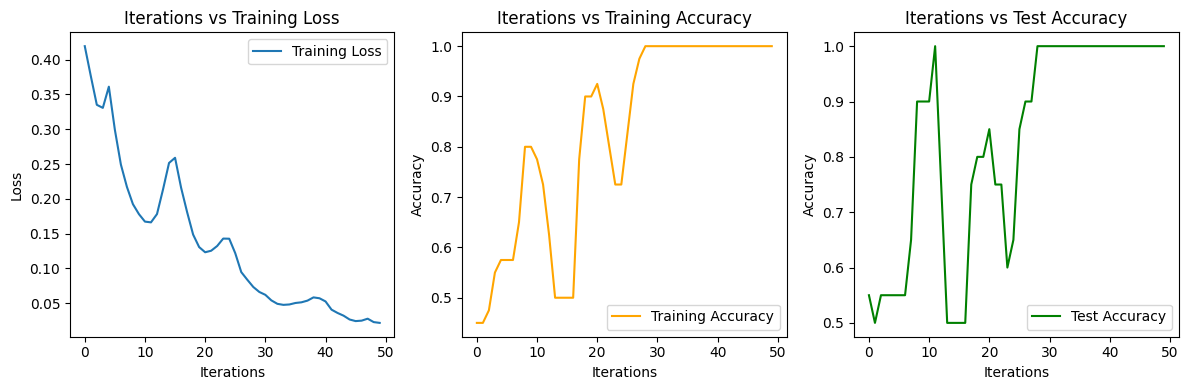

In [17]:
epochs = 50
weights, bias, train_costs, train_accuracies, test_accuracies = train(train_data, train_labels, num_reuploads, AdamOptimizer, learning_rate=0.1, epochs=epochs, batch_size=5)

predictions, accuracy = evaluate(weights, bias, test_data, test_labels)
visualize_performance(test_data, test_labels, predictions)
plot_metrics(range(0, epochs), train_costs, train_accuracies, test_accuracies)

## Compare different classical optimization methods

In [18]:
optimizers = {
    "Adam": AdamOptimizer,
    "GradientDescent": GradientDescentOptimizer,
    "NesterovMomentum": NesterovMomentumOptimizer,
    "RMSProp": RMSPropOptimizer
}

epochs = 50
batch_size = 5

results = pd.DataFrame(columns=["Epoch", "Optimizer", "Learning Rate", "Train Loss", "Train Accuracy", "Test Accuracy"])

for opt_name, optimizer in optimizers.items():
    for lr in [0.5, 0.2, 0.1]:
        weights, bias, train_costs, train_accuracies, test_accuracies = train(train_data,
                                                                              train_labels,
                                                                              num_reuploads,
                                                                              optimizer,
                                                                              learning_rate=lr,
                                                                              epochs=epochs, batch_size=5)

        for epoch in range(epochs):
            new_row = {
                "Epoch": epoch + 1,
                "Optimizer": opt_name,
                "Learning Rate": lr,
                "Train Loss": train_costs[epoch],
                "Train Accuracy": train_accuracies[epoch],
                "Test Accuracy": test_accuracies[epoch]
            }
            results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

print(results)

Iter: 1 | Train Cost: 1.1644 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 2 | Train Cost: 0.9438 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 3 | Train Cost: 0.3164 | Train Accuracy: 0.4750 | Test Accuracy: 0.5000
Iter: 4 | Train Cost: 0.3013 | Train Accuracy: 0.4250 | Test Accuracy: 0.5000
Iter: 5 | Train Cost: 0.5642 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 6 | Train Cost: 0.7095 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 7 | Train Cost: 0.6617 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 8 | Train Cost: 0.4773 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 9 | Train Cost: 0.3438 | Train Accuracy: 0.5000 | Test Accuracy: 0.5000
Iter: 10 | Train Cost: 0.3103 | Train Accuracy: 0.4250 | Test Accuracy: 0.3500
Iter: 11 | Train Cost: 0.2676 | Train Accuracy: 0.4000 | Test Accuracy: 0.2500
Iter: 12 | Train Cost: 0.2207 | Train Accuracy: 0.5750 | Test Accuracy: 0.4000
Iter: 13 | Train Cost: 0.2087 | Train Accuracy: 0.6250 | Test

/tmp/ipython-input-1450904145.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


Iter: 1 | Train Cost: 0.3767 | Train Accuracy: 0.5250 | Test Accuracy: 0.5000
Iter: 2 | Train Cost: 0.3358 | Train Accuracy: 0.4250 | Test Accuracy: 0.5500
Iter: 3 | Train Cost: 0.3143 | Train Accuracy: 0.5750 | Test Accuracy: 0.8000
Iter: 4 | Train Cost: 0.3869 | Train Accuracy: 0.5750 | Test Accuracy: 0.5500
Iter: 5 | Train Cost: 0.4041 | Train Accuracy: 0.4250 | Test Accuracy: 0.5500
Iter: 6 | Train Cost: 0.3391 | Train Accuracy: 0.4000 | Test Accuracy: 0.5500
Iter: 7 | Train Cost: 0.2936 | Train Accuracy: 0.5250 | Test Accuracy: 0.8000
Iter: 8 | Train Cost: 0.2795 | Train Accuracy: 0.3250 | Test Accuracy: 0.5500
Iter: 9 | Train Cost: 0.2808 | Train Accuracy: 0.5750 | Test Accuracy: 0.5000
Iter: 10 | Train Cost: 0.2730 | Train Accuracy: 0.4250 | Test Accuracy: 0.3000
Iter: 11 | Train Cost: 0.2524 | Train Accuracy: 0.5750 | Test Accuracy: 0.4000
Iter: 12 | Train Cost: 0.2653 | Train Accuracy: 0.5000 | Test Accuracy: 0.5500
Iter: 13 | Train Cost: 0.2882 | Train Accuracy: 0.5250 | Test

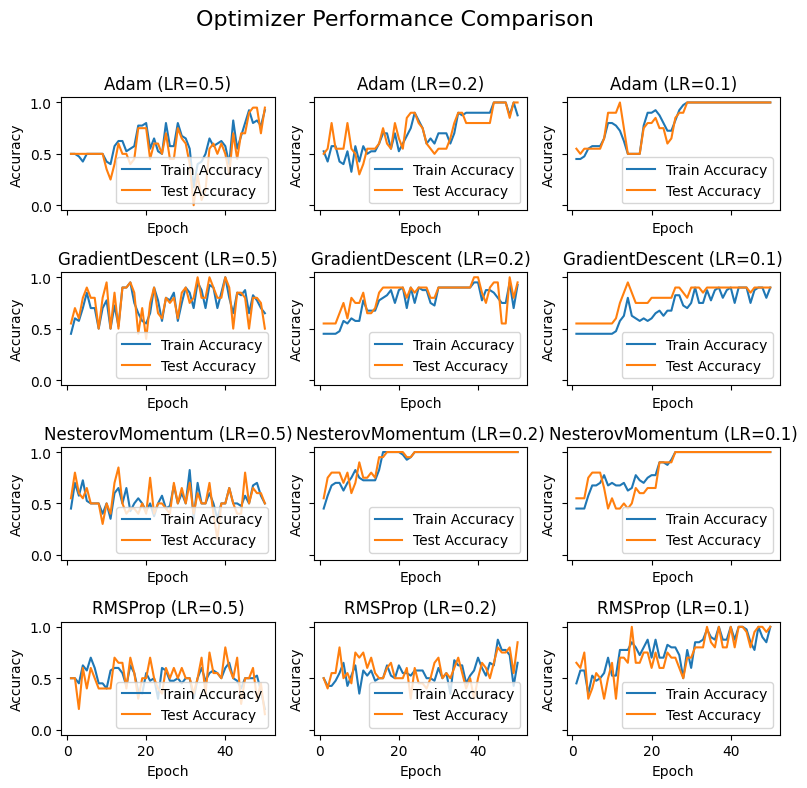

In [19]:
def plot_results(results):
    optimizers = results["Optimizer"].unique()
    learning_rates = results["Learning Rate"].unique()

    fig, axes = plt.subplots(len(optimizers), len(learning_rates), figsize=(8, 8), sharex=True, sharey=True)
    fig.suptitle('Optimizer Performance Comparison', fontsize=16)

    for i, optimizer in enumerate(optimizers):
        for j, lr in enumerate(learning_rates):
            subset = results[(results["Optimizer"] == optimizer) & (results["Learning Rate"] == lr)]
            ax = axes[i, j]
            ax.plot(subset["Epoch"], subset["Train Accuracy"], label="Train Accuracy")
            ax.plot(subset["Epoch"], subset["Test Accuracy"], label="Test Accuracy")
            ax.set_title(f"{optimizer} (LR={lr})")
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy')
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_results(results)

In [20]:
results_best=results[results['Test Accuracy']==results['Test Accuracy'].max()]

def create_latex_table(df):
    table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|}\n\\hline\n"
    table += "Epoch & Optimizer & Learning Rate & Train Loss & Train Accuracy & Test Accuracy \\\\\n\\hline\n"

    for index, row in df.iterrows():
        table += f"{row['Epoch']} & {row['Optimizer']} & {row['Learning Rate']} & "
        table += f"{row['Train Loss']:.4f} & {row['Train Accuracy']:.4f} & {row['Test Accuracy']:.4f} \\\\\n"

    table += "\\hline\n\\end{tabular}\n\\caption{Training and Testing Results}\n\\label{table:results}\n\\end{table}"
    return table

for opt in results_best['Optimizer'].unique():
    results_best_opt = results_best[results_best['Optimizer'] == opt]
    print(f"Results for {opt}")
    print(create_latex_table(results_best_opt))
    print("\n")
latex_table = create_latex_table(results_best)
print(latex_table)


Results for Adam
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Epoch & Optimizer & Learning Rate & Train Loss & Train Accuracy & Test Accuracy \\
\hline
44 & Adam & 0.2 & 0.0704 & 1.0000 & 1.0000 \\
45 & Adam & 0.2 & 0.0791 & 1.0000 & 1.0000 \\
46 & Adam & 0.2 & 0.0605 & 1.0000 & 1.0000 \\
47 & Adam & 0.2 & 0.0712 & 1.0000 & 1.0000 \\
49 & Adam & 0.2 & 0.0892 & 1.0000 & 1.0000 \\
50 & Adam & 0.2 & 0.0861 & 0.8750 & 1.0000 \\
12 & Adam & 0.1 & 0.1661 & 0.7250 & 1.0000 \\
29 & Adam & 0.1 & 0.0732 & 1.0000 & 1.0000 \\
30 & Adam & 0.1 & 0.0660 & 1.0000 & 1.0000 \\
31 & Adam & 0.1 & 0.0619 & 1.0000 & 1.0000 \\
32 & Adam & 0.1 & 0.0539 & 1.0000 & 1.0000 \\
33 & Adam & 0.1 & 0.0490 & 1.0000 & 1.0000 \\
34 & Adam & 0.1 & 0.0475 & 1.0000 & 1.0000 \\
35 & Adam & 0.1 & 0.0481 & 1.0000 & 1.0000 \\
36 & Adam & 0.1 & 0.0502 & 1.0000 & 1.0000 \\
37 & Adam & 0.1 & 0.0512 & 1.0000 & 1.0000 \\
38 & Adam & 0.1 & 0.0536 & 1.0000 & 1.0000 \\
39 & Adam & 0.1 & 0.0582 & 1.0000 & 1.0000 \

In [21]:
results_best=results[results['Test Accuracy']==results['Test Accuracy'].max()]

def create_latex_table(df):
    table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|}\n\\hline\n"
    table += "Epoch & Optimizer & Learning Rate & Train Loss & Train Accuracy & Test Accuracy \\\\\n\\hline\n"

    for index, row in df.iterrows():
        table += f"{row['Epoch']} & {row['Optimizer']} & {row['Learning Rate']} & "
        table += f"{row['Train Loss']:.4f} & {row['Train Accuracy']:.4f} & {row['Test Accuracy']:.4f} \\\\\n"

    table += "\\hline\n\\end{tabular}\n\\caption{Training and Testing Results}\n\\label{table:results}\n\\end{table}"
    return table

latex_table = create_latex_table(results_best)
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Epoch & Optimizer & Learning Rate & Train Loss & Train Accuracy & Test Accuracy \\
\hline
44 & Adam & 0.2 & 0.0704 & 1.0000 & 1.0000 \\
45 & Adam & 0.2 & 0.0791 & 1.0000 & 1.0000 \\
46 & Adam & 0.2 & 0.0605 & 1.0000 & 1.0000 \\
47 & Adam & 0.2 & 0.0712 & 1.0000 & 1.0000 \\
49 & Adam & 0.2 & 0.0892 & 1.0000 & 1.0000 \\
50 & Adam & 0.2 & 0.0861 & 0.8750 & 1.0000 \\
12 & Adam & 0.1 & 0.1661 & 0.7250 & 1.0000 \\
29 & Adam & 0.1 & 0.0732 & 1.0000 & 1.0000 \\
30 & Adam & 0.1 & 0.0660 & 1.0000 & 1.0000 \\
31 & Adam & 0.1 & 0.0619 & 1.0000 & 1.0000 \\
32 & Adam & 0.1 & 0.0539 & 1.0000 & 1.0000 \\
33 & Adam & 0.1 & 0.0490 & 1.0000 & 1.0000 \\
34 & Adam & 0.1 & 0.0475 & 1.0000 & 1.0000 \\
35 & Adam & 0.1 & 0.0481 & 1.0000 & 1.0000 \\
36 & Adam & 0.1 & 0.0502 & 1.0000 & 1.0000 \\
37 & Adam & 0.1 & 0.0512 & 1.0000 & 1.0000 \\
38 & Adam & 0.1 & 0.0536 & 1.0000 & 1.0000 \\
39 & Adam & 0.1 & 0.0582 & 1.0000 & 1.0000 \\
40 & Adam & 0.1